In [1]:
from pathlib import Path

import numpy as np
from zanj import ZANJ

from maze_dataset import MazeDatasetConfig
from maze_dataset.generation import LatticeMazeGenerators
from maze_dataset.benchmark.config_sweep import (
    SweepResult,
    full_percolation_analysis,
    dataset_success_fraction,
    plot_grouped,
)
from maze_dataset.benchmark.sweep_fit import sweep_fit

f:\KNC\maze-dataset\.venv\Lib\site-packages\juliacall\__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


# run a basic analysis

tqdm_allowed_kwargs = {'initial', 'leave', 'colour', 'nrows', 'total', 'delay', 'maxinterval', 'smoothing', 'desc', 'mininterval', 'gui', 'lock_args', 'ncols', 'unit_scale', 'iterable', 'dynamic_ncols', 'ascii', 'bar_format', 'unit', 'file', 'postfix', 'miniters', 'write_bytes', 'unit_divisor', 'self', 'disable', 'position'}
mapped_kwargs = {'total': 3, 'desc': 'Processing 3 items'}


Processing 3 items: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


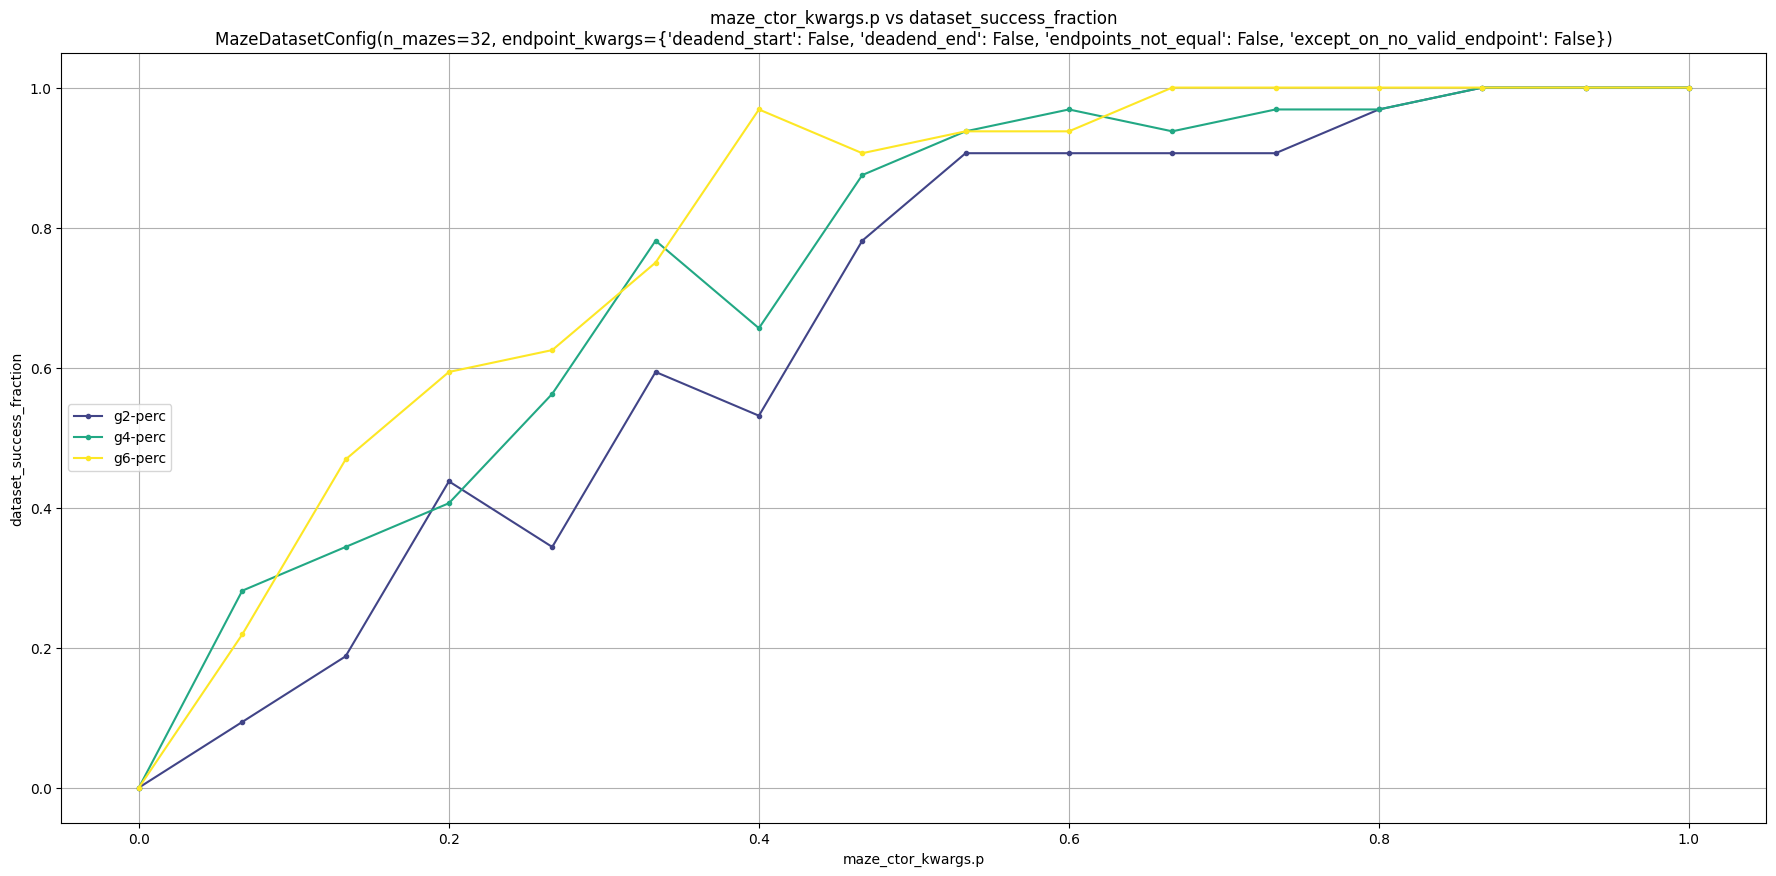

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [2]:
# Run the analysis
results: SweepResult = SweepResult.analyze(
    configs=[
        MazeDatasetConfig(
            name=f"g{grid_n}-perc",
            grid_n=grid_n,
            n_mazes=32,
            maze_ctor=LatticeMazeGenerators.gen_percolation,
            maze_ctor_kwargs=dict(),
            endpoint_kwargs=dict(
                deadend_start=False,
                deadend_end=False,
                endpoints_not_equal=False,
                except_on_no_valid_endpoint=False,
            ),
        )
        for grid_n in [2, 4, 6]
    ],
    param_values=np.linspace(0.0, 1.0, 16).tolist(),
    param_key="maze_ctor_kwargs.p",
    analyze_func=dataset_success_fraction,
    parallel=False,
)

# Plot results
results.plot(save_path=None, cfg_keys=["n_mazes", "endpoint_kwargs"])


## check saving/loading

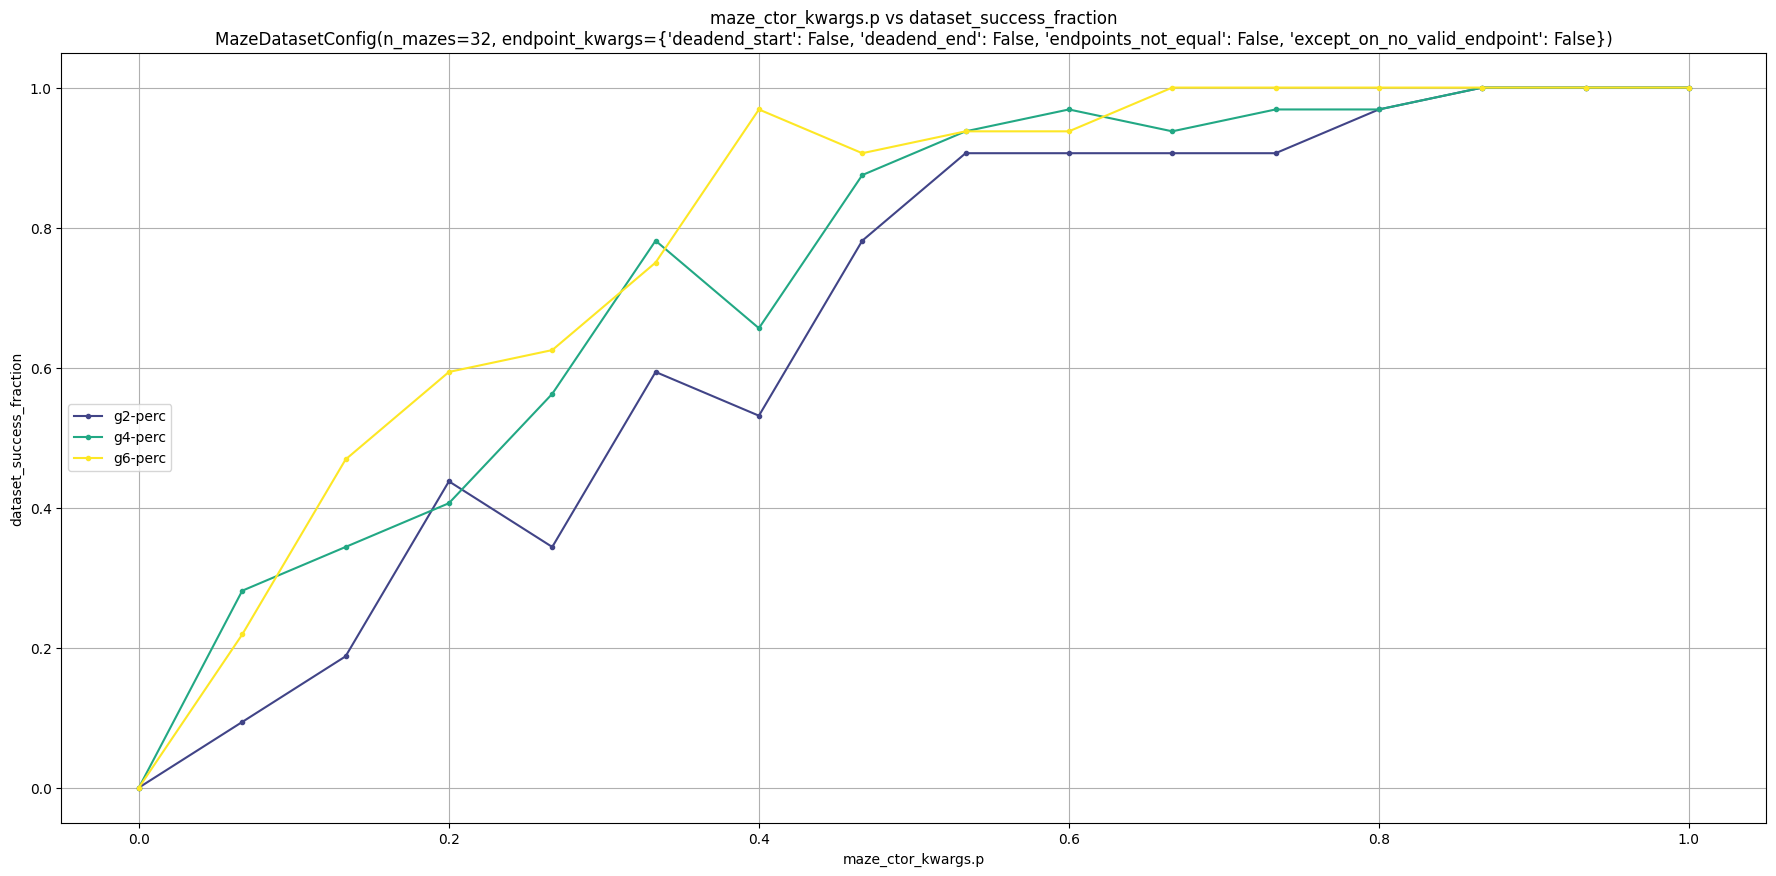

<Axes: title={'center': "maze_ctor_kwargs.p vs dataset_success_fraction\nMazeDatasetConfig(n_mazes=32, endpoint_kwargs={'deadend_start': False, 'deadend_end': False, 'endpoints_not_equal': False, 'except_on_no_valid_endpoint': False})"}, xlabel='maze_ctor_kwargs.p', ylabel='dataset_success_fraction'>

In [3]:
path = Path("../tests/_temp/dataset_frac_sweep/results_small.zanj")
results.save(path)
ZANJ().read(path).plot(cfg_keys=["n_mazes", "endpoint_kwargs"])

# sweep acrossall endpoint kwargs and generator funcs 

In [4]:
results_full: SweepResult = full_percolation_analysis(
    n_mazes=16,
    p_val_count=16,
    grid_sizes=[2, 4, 6],
    parallel=False,
)

tqdm_allowed_kwargs = {'initial', 'leave', 'colour', 'nrows', 'total', 'delay', 'maxinterval', 'smoothing', 'desc', 'mininterval', 'gui', 'lock_args', 'ncols', 'unit_scale', 'iterable', 'dynamic_ncols', 'ascii', 'bar_format', 'unit', 'file', 'postfix', 'miniters', 'write_bytes', 'unit_divisor', 'self', 'disable', 'position'}
mapped_kwargs = {'total': 18, 'desc': 'Processing 18 items'}


Processing 18 items: 100%|██████████| 18/18 [00:13<00:00,  1.36it/s]


Saving results to ../docs/benchmarks/percolation_fractions/result-n16-c18-p16.zanj


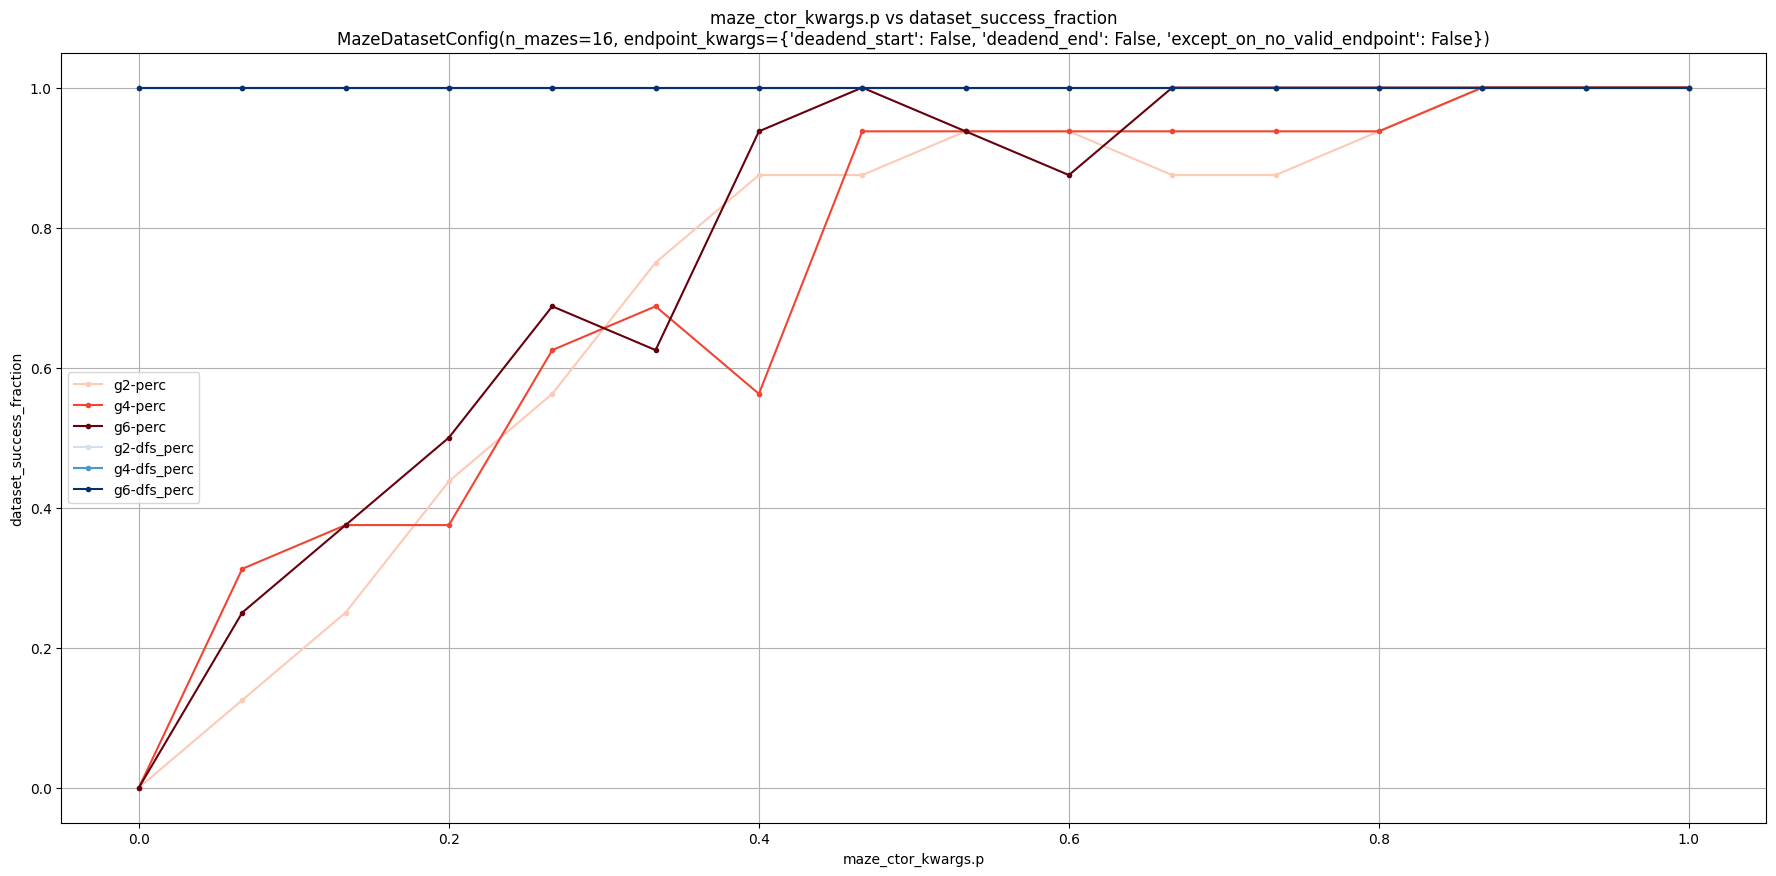

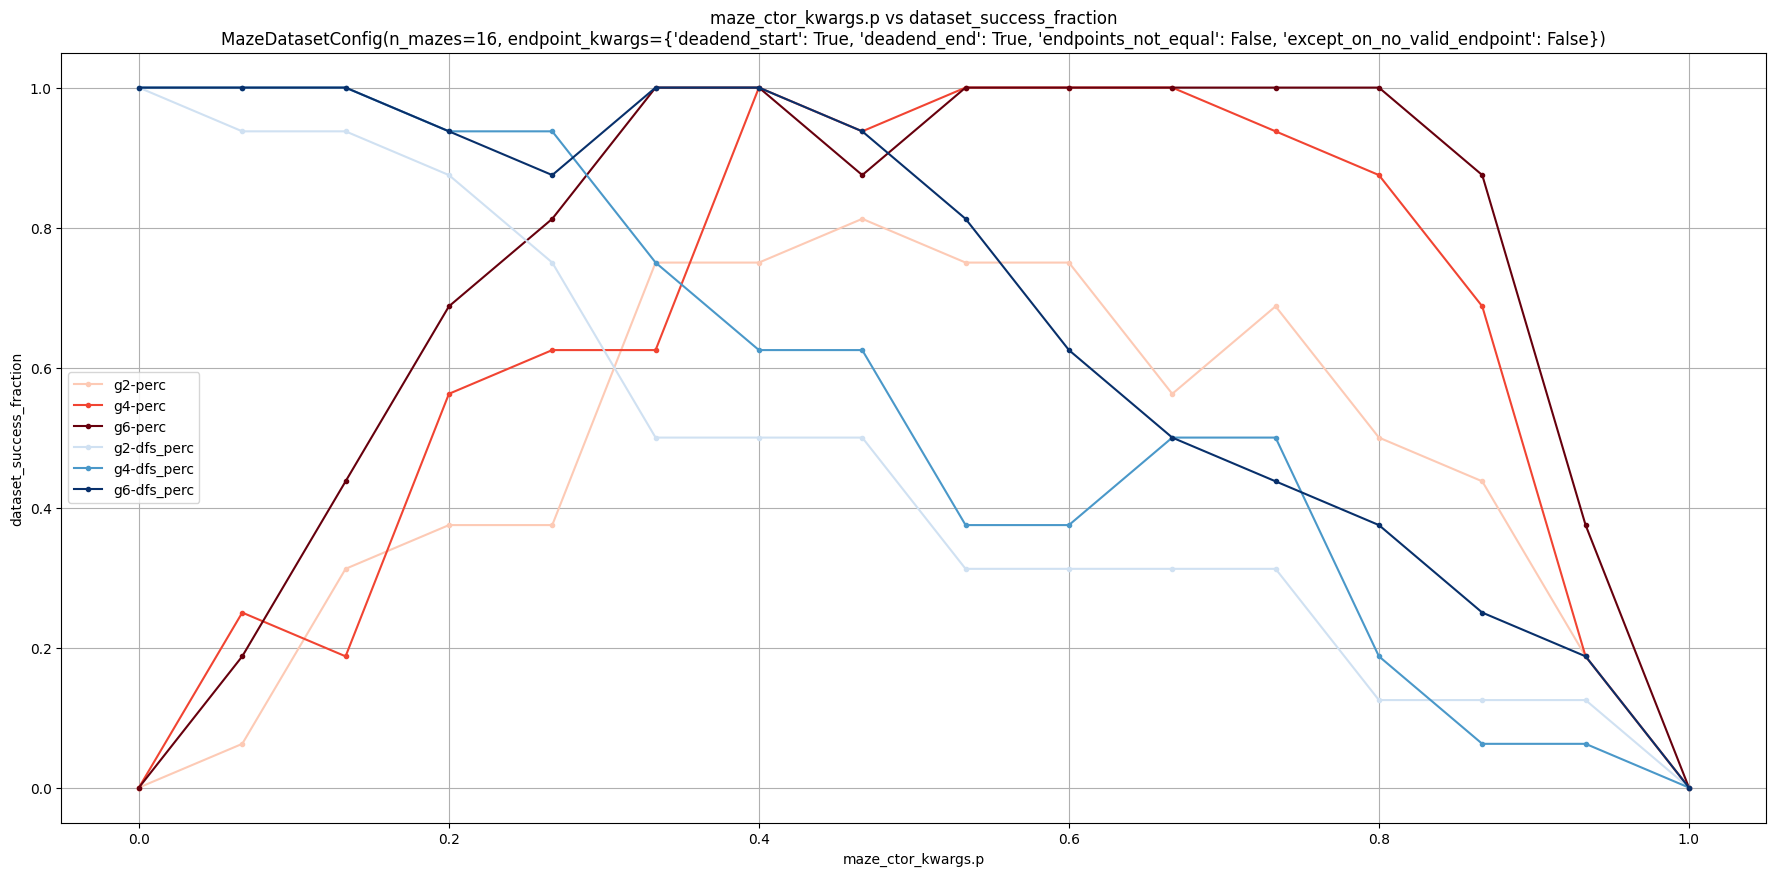

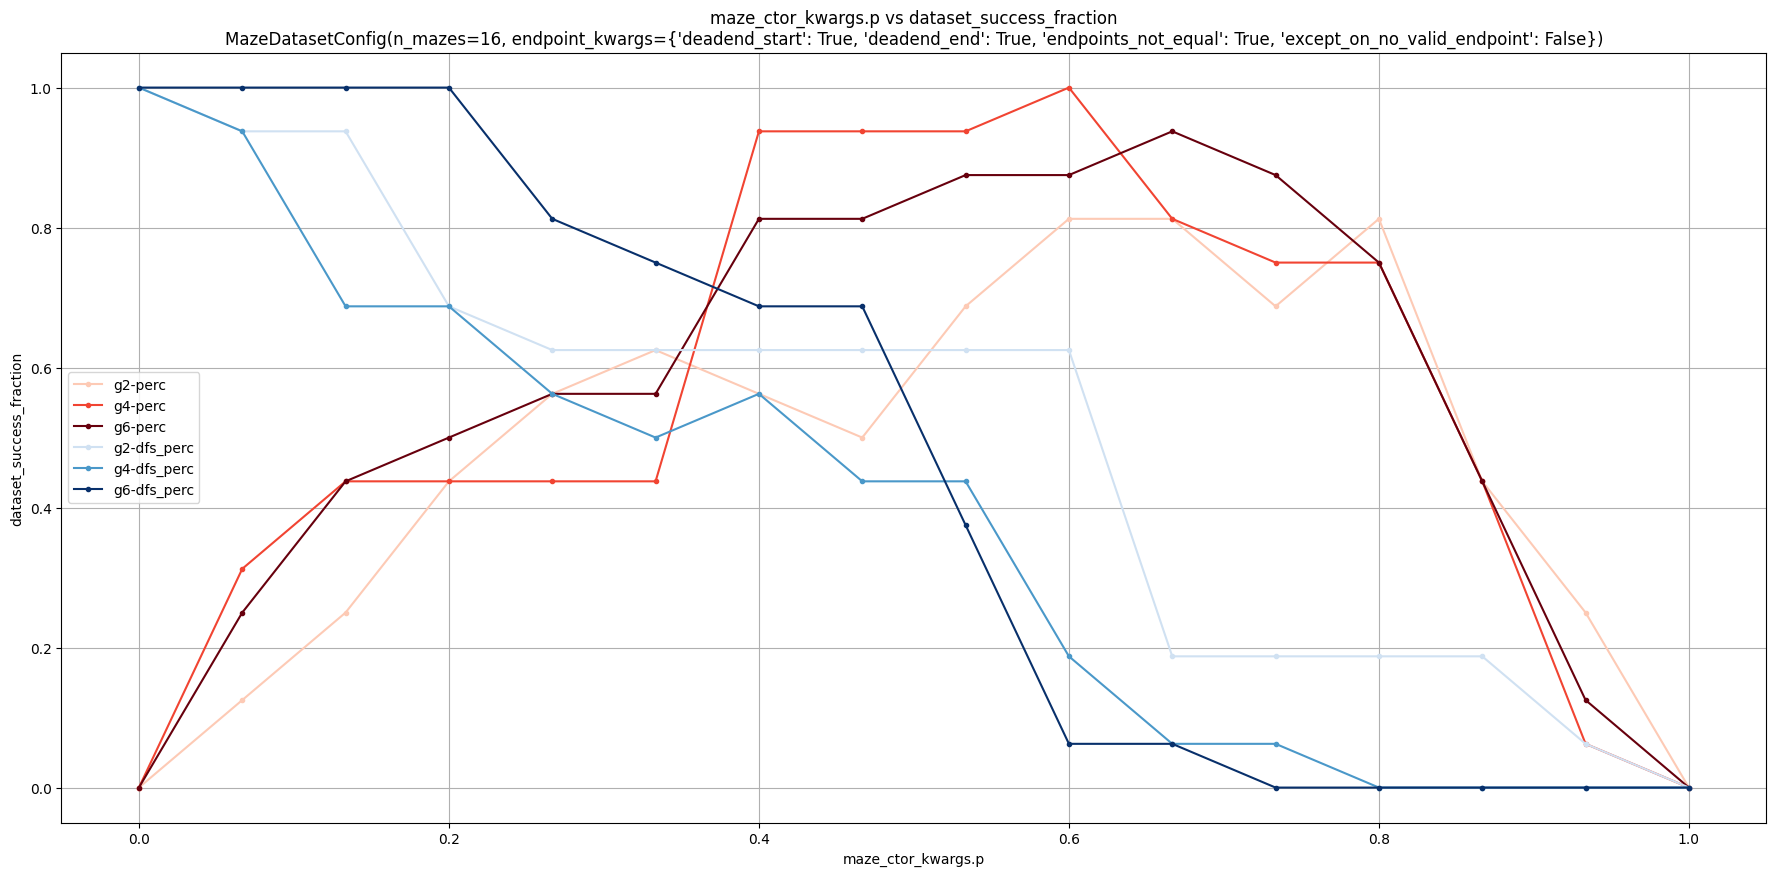

In [5]:
plot_grouped(results_full)

# perform a pysr regression on a dataset we load

training data extracted: X.shape = (2100, 5), y.shape = (2100,)
Compiling Julia backend...


f:\KNC\maze-dataset\.venv\Lib\site-packages\pysr\sr.py:2780: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 4.400e+04
Progress: 308 / 620 total iterations (49.677%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.119e-01  1.594e+01  y = 0.67806
3           1.116e-01  1.482e-03  y = sigmoid(sigmoid(x₃))
4           9.314e-02  1.807e-01  y = 1.3321 - sigmoid(x₂)
5           9.257e-02  6.190e-03  y = sigmoid(square(x₂ - 1.5057))
6           9.214e-02  4.687e-03  y = sigmoid(x₂ * -1.3763) + 0.37698
7           8.907e-02  3.382e-02  y = sigmoid((1.4128 - cube(x₀)) - x₂)
8           8.513e-02  4.532e-02  y = sigmoid((1.5349 - cube(cube(x₀))) - x₂)
9           8.486e-02  3.149e-03  y = sigmoid((1.3785 - cube(x₀)) - (x₂ - 0.32356))
10          8.405e-02  9.520e-03  y = sigmoid(square((x₂ - x₀) - square(x₂ - 1.1034)))
11          8.092e-02  3.795e-02  y = sigm

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.119e-01  1.594e+01  y = 0.67806
3           1.116e-01  1.482e-03  y = sigmoid(sigmoid(x₃))
4           9.314e-02  1.807e-01  y = 1.3321 - sigmoid(x₂)
5           9.237e-02  8.304e-03  y = 0.98021 - cube(sigmoid(x₂))
6           9.214e-02  2.573e-03  y = sigmoid(x₂ * -1.3763) + 0.37698
7           8.907e-02  3.382e-02  y = sigmoid((1.4128 - cube(x₀)) - x₂)
8           8.513e-02  4.532e-02  y = sigmoid((1.5349 - cube(cube(x₀))) - x₂)
9           7.491e-02  1.278e-01  y = sigmoid(log(1.0039 - (x₂ * x₀)) - -1.3379)
11          6.704e-02  5.548e-02  y = sigmoid(cube(((x₄ * -0.73171) - x₂) * x₀) - -1.2673)
13          5.550e-02  9.448e-02  y = sigmoid(cube(((x₄ * -0.6794) - x₀) * x₂) - (-0.99578 -...
                                       x₄))
15          5.219e-02  3.071e-02  y = sigmoid(cube(x₂ * ((x₄ * -0.78638) - x₀)) - ((-0.78638...

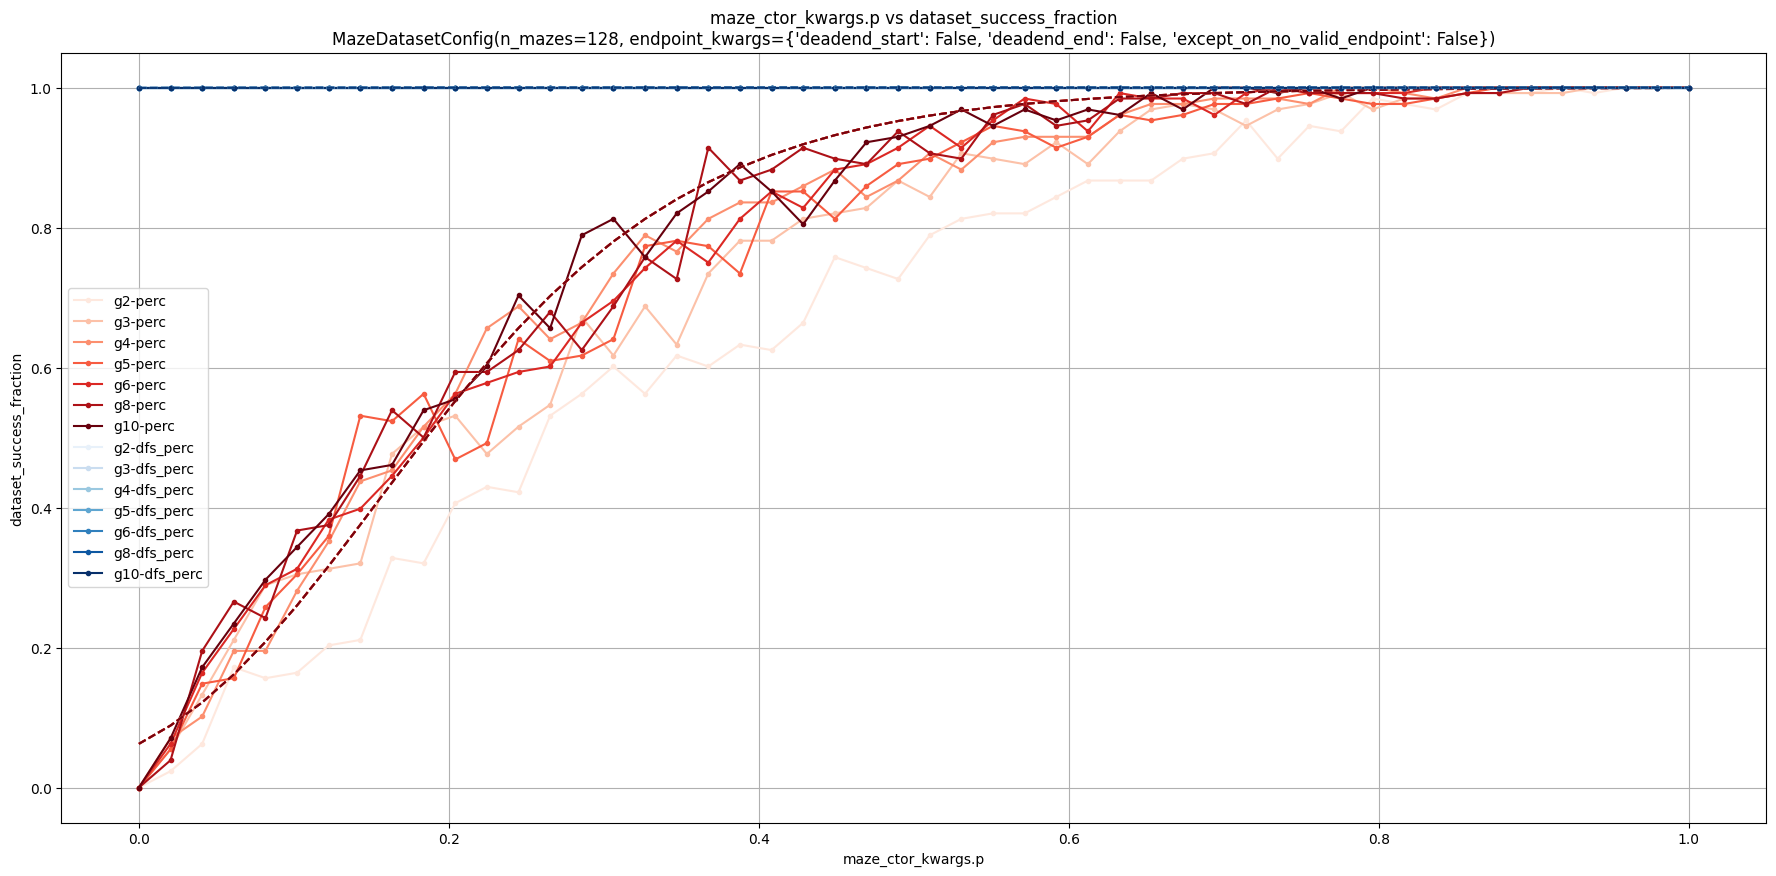

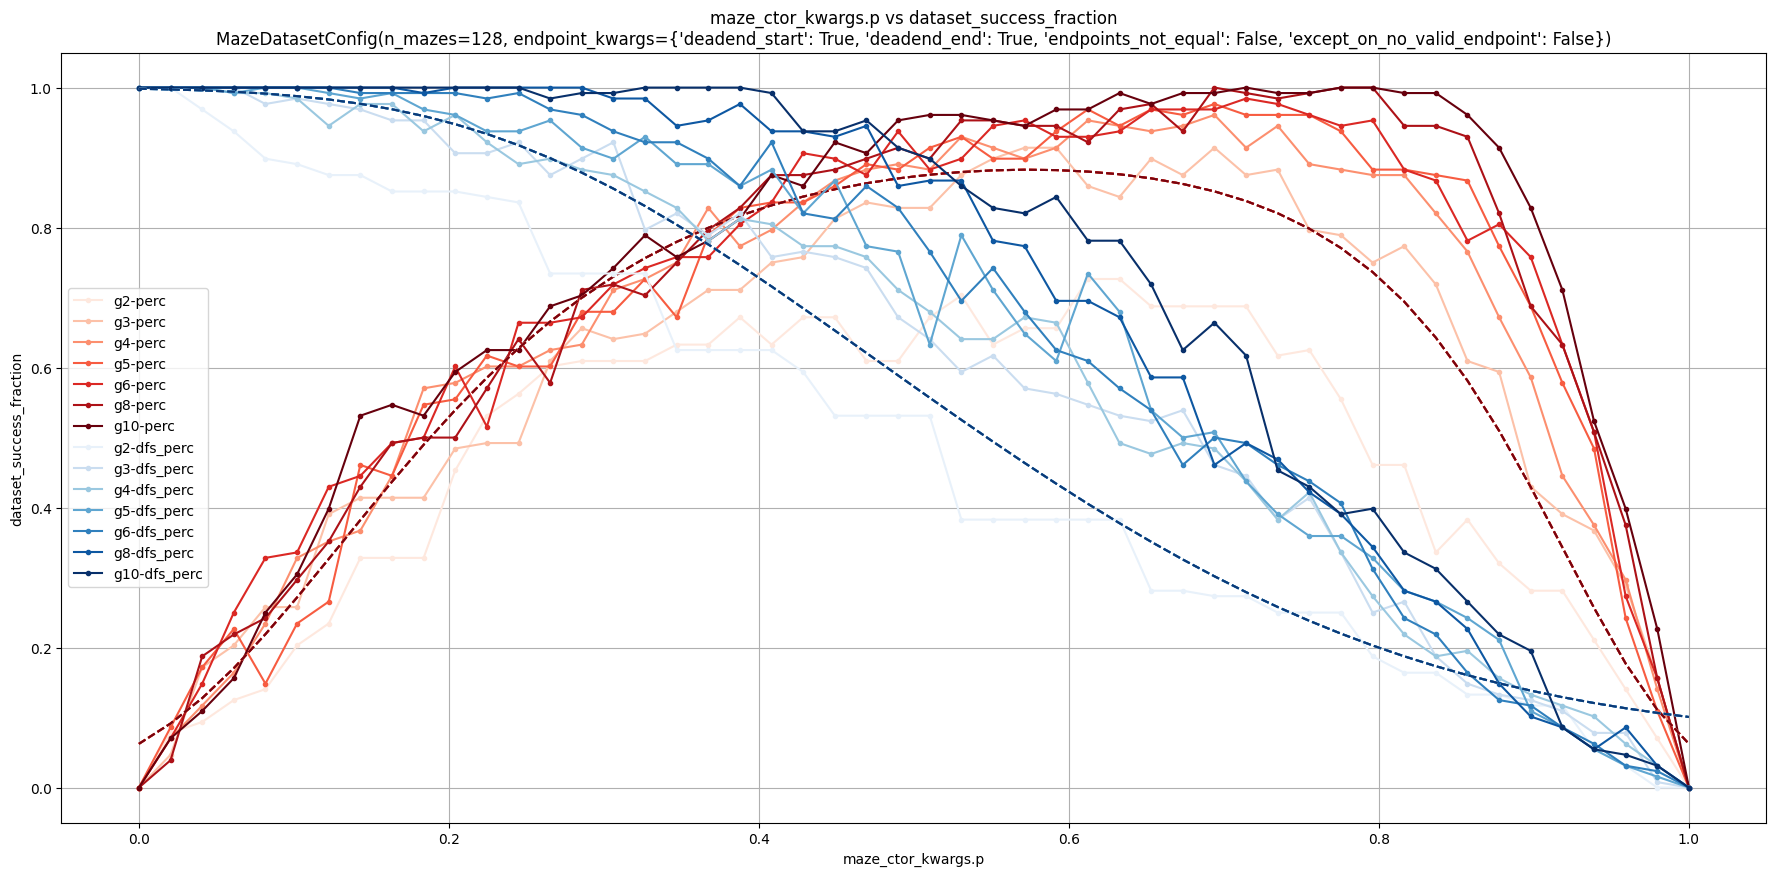

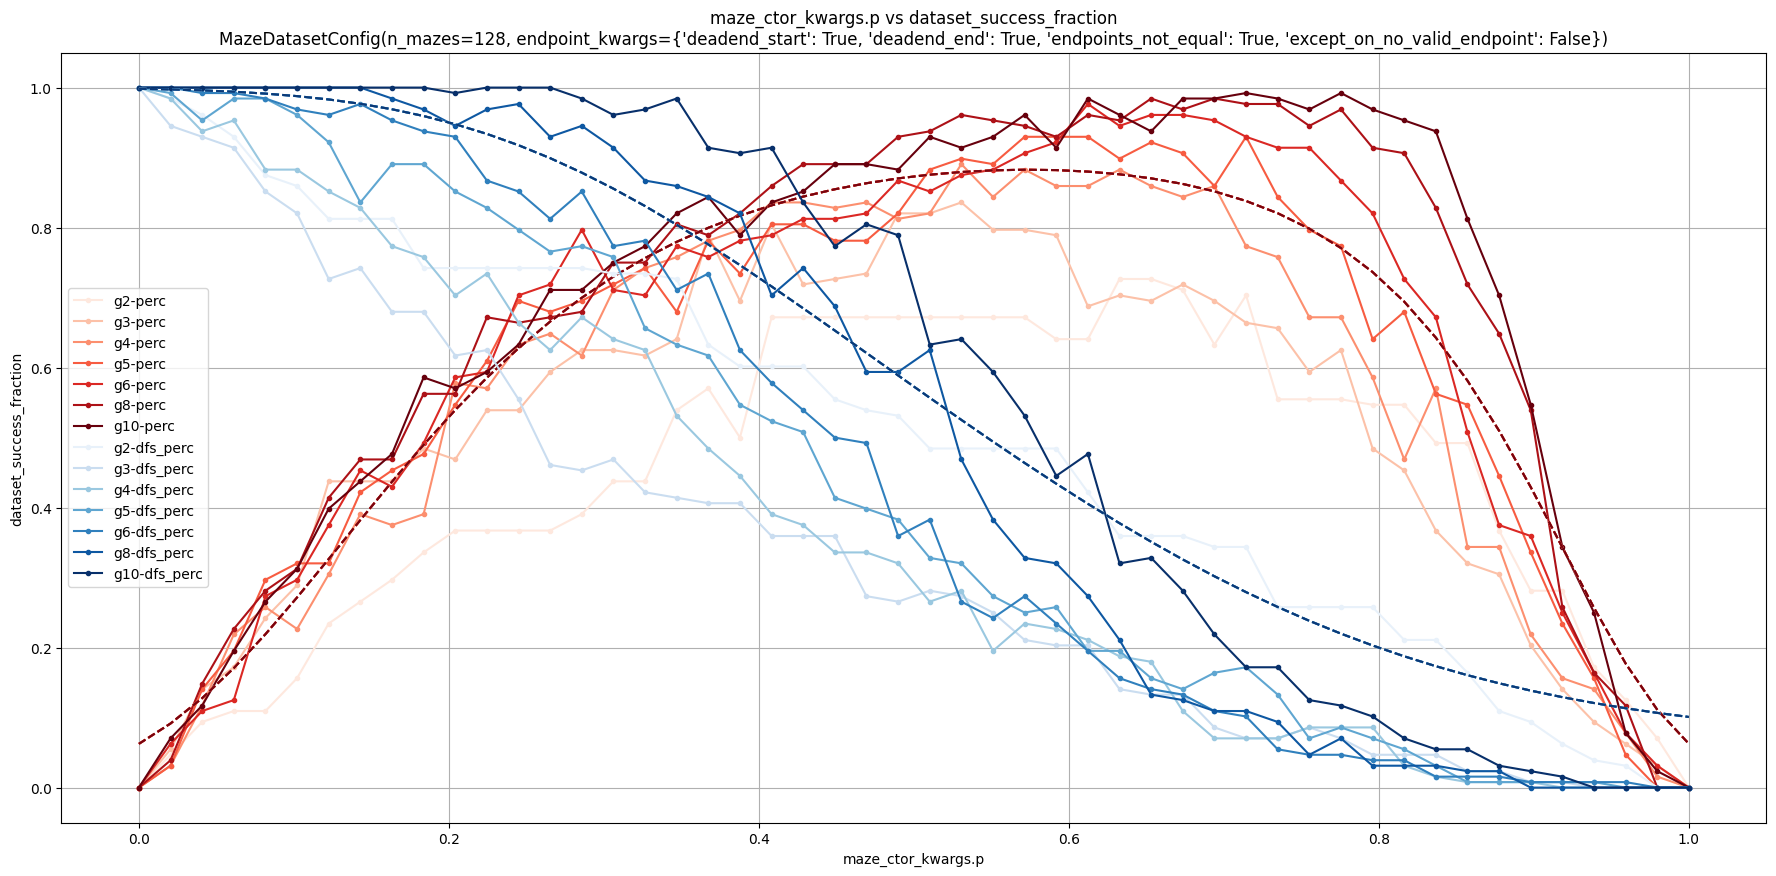

In [6]:
DATA_PATH_DIR: Path = Path("../docs/benchmarks/percolation_fractions/")
# DATA_PATH: str = DATA_PATH_DIR / "large/result-n256-c54-p100.zanj"
DATA_PATH: str = DATA_PATH_DIR / "medium/result-n128-c42-p50.zanj"
# DATA_PATH: str = DATA_PATH_DIR / "small/result-n64-c30-p25.zanj"
# DATA_PATH: str = DATA_PATH_DIR / "test/result-n16-c12-p16.zanj"

sweep_fit(
    DATA_PATH,
    Path("../docs/benchmarks/percolation_fractions/fit_plots/"),
    niterations=20,
)